# `RAG` with MongoDB

### Overall Architecture

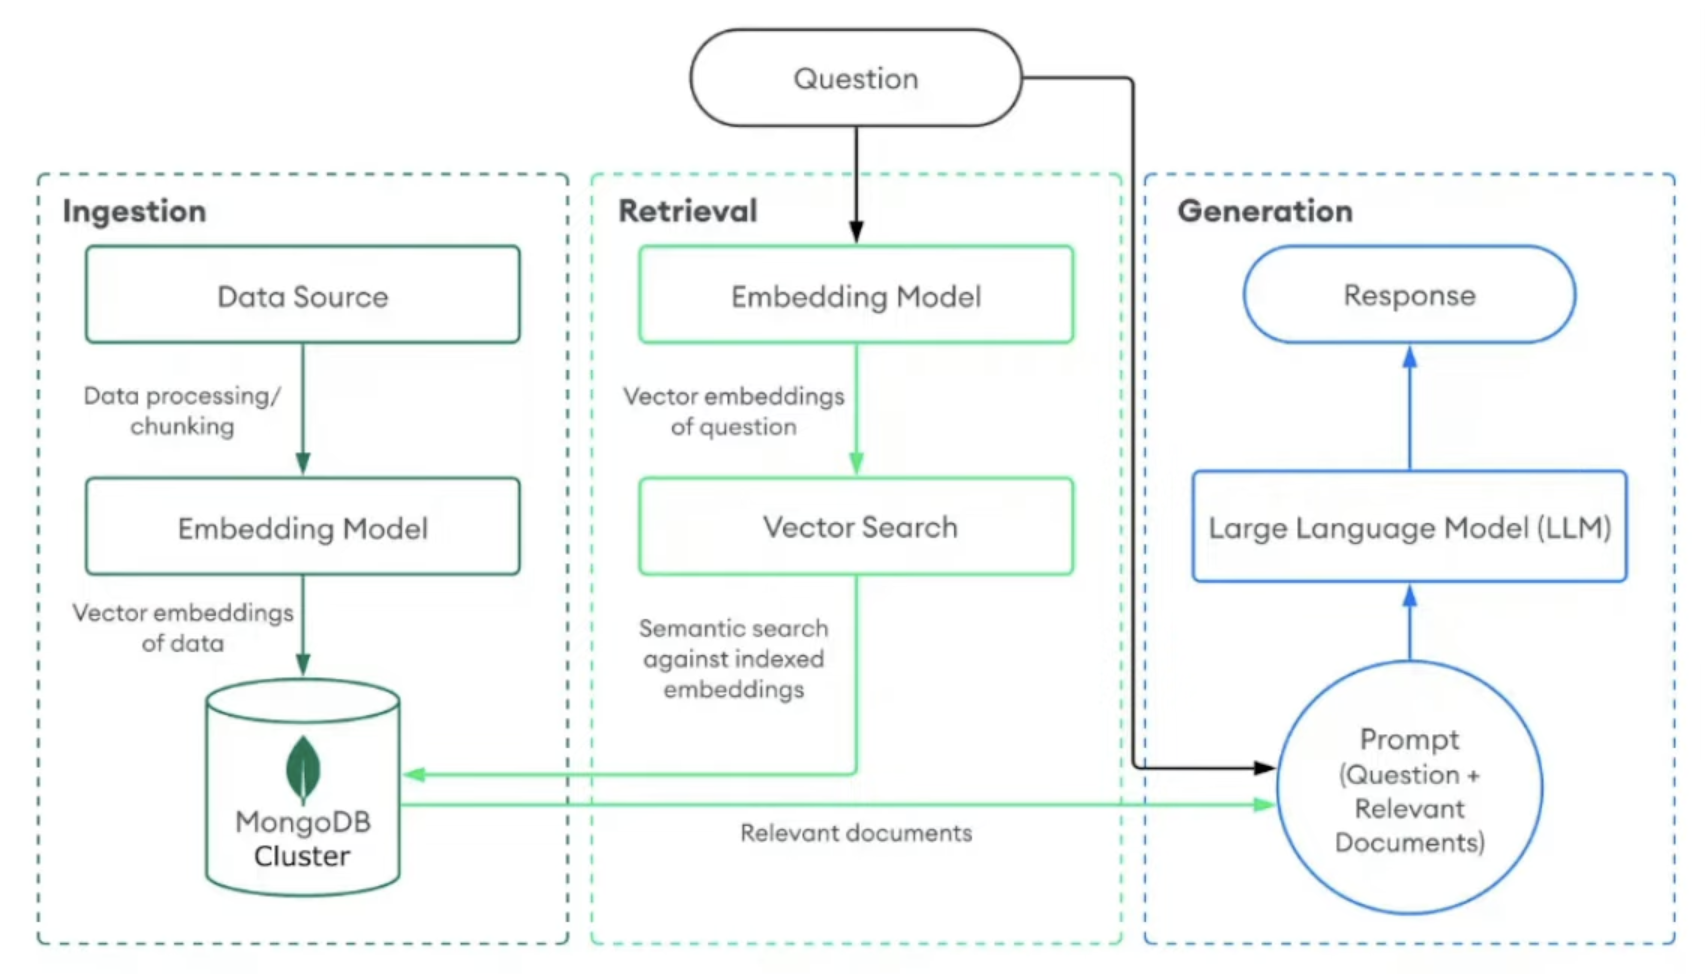

## 1. Data Ingeston

In [3]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [28]:
from openai import OpenAI

# Initialize the OpenAI client
open_ai_client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# Specify the embedding model
model = "text-embedding-3-large"

# Define the function to generate embeddings
def get_embeddings(text, input_type="document"):
    response = open_ai_client.embeddings.create(
        model=model,
        input=text
    )
    return response.data[0].embedding

In [29]:
# Get embeddings for a given text
embed = get_embeddings("Retrieval Augmented Generation")
embed

[-0.0183663722127676,
 0.01043037697672844,
 -0.020133227109909058,
 -0.004751204047352076,
 -0.00650321040302515,
 0.010630819015204906,
 -0.027141252532601357,
 0.038811396807432175,
 -0.026443418115377426,
 0.020563803613185883,
 0.021172551438212395,
 -0.036406099796295166,
 0.015263242647051811,
 -0.018143659457564354,
 -0.011640449054539204,
 0.000426633981987834,
 -0.024914124980568886,
 0.008129012770950794,
 -0.002882273169234395,
 -0.02685914933681488,
 0.004135032184422016,
 -0.015396869741380215,
 -0.051075439900159836,
 0.007572231348603964,
 0.01677768863737583,
 -0.009895866736769676,
 -0.0025407804641872644,
 0.00712680583819747,
 -0.014424357563257217,
 0.04323595389723778,
 0.038900479674339294,
 0.016510432586073875,
 0.036376405507326126,
 -0.039642855525016785,
 -0.006265650037676096,
 0.05769743025302887,
 0.011803772300481796,
 0.03762359544634819,
 -0.0015469251666218042,
 -0.005382223054766655,
 0.020994381979107857,
 -0.027126403525471687,
 0.0020192617084831,

In [30]:
# Embedding Length
len(embed)

3072

In [31]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Loading the PDF file
loader = PyPDFLoader("https://arxiv.org/pdf/1506.02640.pdf")
documents = loader.load()

# Splitting the documents into chunks
splitter = RecursiveCharacterTextSplitter(chunk_size=400, chunk_overlap=20)
splitted_documents = splitter.split_documents(documents)

In [32]:
# Loading the PDF file (and splitting it into chunks)
documents

[Document(metadata={'producer': 'pdfTeX-1.40.12', 'creator': 'LaTeX with hyperref package', 'creationdate': '2016-05-11T00:04:54+00:00', 'author': '', 'keywords': '', 'moddate': '2016-05-11T00:04:54+00:00', 'ptex.fullbanner': 'This is pdfTeX, Version 3.1415926-2.3-1.40.12 (TeX Live 2011) kpathsea version 6.0.1', 'subject': '', 'title': '', 'trapped': '/False', 'source': 'https://arxiv.org/pdf/1506.02640.pdf', 'total_pages': 10, 'page': 0, 'page_label': '1'}, page_content='You Only Look Once:\nUniﬁed, Real-Time Object Detection\nJoseph Redmon∗, Santosh Divvala∗†, Ross Girshick¶, Ali Farhadi∗†\nUniversity of Washington∗, Allen Institute for AI†, Facebook AI Research¶\nhttp://pjreddie.com/yolo/\nAbstract\nWe present YOLO, a new approach to object detection.\nPrior work on object detection repurposes classiﬁers to per-\nform detection. Instead, we frame object detection as a re-\ngression problem to spatially separated bounding boxes and\nassociated class probabilities. A single neural net

In [33]:
# Converting PDF text chunks into embeddings

docs_to_insert = [
  {
    "text": doc.page_content,
    "embedding": get_embeddings(doc.page_content)
  } for doc in documents
]

In [34]:
docs_to_insert

[{'text': 'You Only Look Once:\nUniﬁed, Real-Time Object Detection\nJoseph Redmon∗, Santosh Divvala∗†, Ross Girshick¶, Ali Farhadi∗†\nUniversity of Washington∗, Allen Institute for AI†, Facebook AI Research¶\nhttp://pjreddie.com/yolo/\nAbstract\nWe present YOLO, a new approach to object detection.\nPrior work on object detection repurposes classiﬁers to per-\nform detection. Instead, we frame object detection as a re-\ngression problem to spatially separated bounding boxes and\nassociated class probabilities. A single neural network pre-\ndicts bounding boxes and class probabilities directly from\nfull images in one evaluation. Since the whole detection\npipeline is a single network, it can be optimized end-to-end\ndirectly on detection performance.\nOur uniﬁed architecture is extremely fast. Our base\nYOLO model processes images in real-time at 45 frames\nper second. A smaller version of the network, Fast YOLO,\nprocesses an astounding 155 frames per second while\nstill achieving doub

In [ ]:
# Creating connection to MongoDB Deployment

from pymongo import MongoClient

client = MongoClient("mongodb+srv://<db_user_name>:<db_pwd>@<clutser_name>.mdmz1v0.mongodb.net/?appName=<cluster_name>")
collection = client["<db_name>"]["<collection_name>"]

# Inserting the documents into the collection (the chunks)
result = collection.insert_many(docs_to_insert)
result

InsertManyResult([ObjectId('69532380e5572498483e57be'), ObjectId('69532380e5572498483e57bf'), ObjectId('69532380e5572498483e57c0'), ObjectId('69532380e5572498483e57c1'), ObjectId('69532380e5572498483e57c2'), ObjectId('69532380e5572498483e57c3'), ObjectId('69532380e5572498483e57c4'), ObjectId('69532380e5572498483e57c5'), ObjectId('69532380e5572498483e57c6'), ObjectId('69532380e5572498483e57c7')], acknowledged=True)

<br>

# 2. Retrieval

In [36]:
from pymongo.operations import SearchIndexModel
import time

# Creating the index model --> creating the search index
index_name="vector_index"
search_index_model = SearchIndexModel(
  definition={
    "fields" : [
      {
        "type" : "vector", # type of the index
        "numDimensions" : 3072, # dimension of the vector
        "path" : "embedding", # path to the vector
        "similarity" : "cosine" # similarity metric
      }
    ] 
  },
  name=index_name,
  type="vectorSearch"
)
collection.create_search_index(model=search_index_model)

'vector_index'

In [37]:
# Send a ping to confirm a successful connection
try:
    client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)


Pinged your deployment. You successfully connected to MongoDB!


In [38]:
# Waiting for initial sync to complete
print("Polling to check if the index is ready. This may take up to a minute.")
predicate=None

if predicate is None:
  predicate = lambda index: index.get("queryable") is True

while True:
  indices = list(collection.list_search_indexes (index_name))
  if len(indices) and predicate(indices[0]):
    break
  time.sleep(5)

print(index_name + " is ready for querying.")

Polling to check if the index is ready. This may take up to a minute.
vector_index is ready for querying.


In [59]:
query_embedding = get_embeddings("YOLO")
query_embedding

[-0.039971038699150085,
 -0.005306500010192394,
 -0.0030516681727021933,
 0.013783116824924946,
 0.009088242426514626,
 0.0005510554765351117,
 -0.026446355506777763,
 0.057544514536857605,
 -0.03972983360290527,
 0.020226724445819855,
 -0.008679056540131569,
 0.02479238249361515,
 0.03538815304636955,
 0.01459287479519844,
 -0.02181178331375122,
 0.017349498346447945,
 -0.033510204404592514,
 -0.014437815174460411,
 -0.0072189075872302055,
 -0.01979600265622139,
 0.016152089461684227,
 -0.019813230261206627,
 -0.045070793479681015,
 -0.0037623601965606213,
 0.01697046309709549,
 0.004302917048335075,
 -0.0054572527296841145,
 0.009036555886268616,
 -0.03928188234567642,
 -0.03700767084956169,
 0.02873779833316803,
 0.028858400881290436,
 0.03433718904852867,
 -0.0405912809073925,
 -0.00804158765822649,
 0.040177784860134125,
 0.027807438746094704,
 -0.02630852535367012,
 -0.014980525709688663,
 0.014610104262828827,
 0.025171417742967606,
 -0.024654550477862358,
 -0.051135364919900894

In [60]:
results = collection.RAGMongoDB.aggregate( # MongoDB Vector Search
  [
    {
      "$vectorSearch" : {
        "index": "vector_index", # Name of the vector index
        "path": "embedding", # Path to the vector field
        "queryVector": query_embedding, # Query Embedding
        "numCandidates": 3072, # Number of candidates to consider
        "limit": 5 # Number of results to return
      }
    }
  ]
)

In [61]:
results

In [62]:
array_of_results = []
for doc in results:
  array_of_results.append(doc)

In [63]:
array_of_results

[]

In [64]:
# Defining a function to run vector search queries

def get_query_results(query):
  """Get query results from the vector search query."""

  query_embeddings = get_embeddings(query, input_type="query")
  print(query_embeddings) # Print the query embeddings

  pipeline = [
    {
      "$vectorSearch" : {
        "index": "vector_index", # Name of the vector index
        "path": "embedding", # Path to the vector field
        "queryVector": query_embedding, # Query Embedding
        "numCandidates": 3072, # Number of candidates to consider
        "limit": 5 # Number of results to return
      }
    },
    {
      "$project": {
        "_id": 0,
        "text": 1
      }
    }
  ]

  # After getting results (if any)
  results = collection.aggregate(pipeline)
  print(results)

  array_of_results = []
  for doc in results:
    array_of_results.append(doc)

  return array_of_results


In [65]:
# Search 

get_query_results("YOLO")

[-0.039971038699150085, -0.005306500010192394, -0.0030516681727021933, 0.013783116824924946, 0.009088242426514626, 0.0005510554765351117, -0.026446355506777763, 0.057544514536857605, -0.03972983360290527, 0.020226724445819855, -0.008679056540131569, 0.02479238249361515, 0.03538815304636955, 0.01459287479519844, -0.02181178331375122, 0.017349498346447945, -0.033510204404592514, -0.014437815174460411, -0.0072189075872302055, -0.01979600265622139, 0.016152089461684227, -0.019813230261206627, -0.045070793479681015, -0.0037623601965606213, 0.01697046309709549, 0.004302917048335075, -0.0054572527296841145, 0.009036555886268616, -0.03928188234567642, -0.03700767084956169, 0.02873779833316803, 0.028858400881290436, 0.03433718904852867, -0.0405912809073925, -0.00804158765822649, 0.040177784860134125, 0.027807438746094704, -0.02630852535367012, -0.014980525709688663, 0.014610104262828827, 0.025171417742967606, -0.024654550477862358, -0.051135364919900894, 0.037903573364019394, 0.0070466184988617

[{'text': 'You Only Look Once:\nUniﬁed, Real-Time Object Detection\nJoseph Redmon∗, Santosh Divvala∗†, Ross Girshick¶, Ali Farhadi∗†\nUniversity of Washington∗, Allen Institute for AI†, Facebook AI Research¶\nhttp://pjreddie.com/yolo/\nAbstract\nWe present YOLO, a new approach to object detection.\nPrior work on object detection repurposes classiﬁers to per-\nform detection. Instead, we frame object detection as a re-\ngression problem to spatially separated bounding boxes and\nassociated class probabilities. A single neural network pre-\ndicts bounding boxes and class probabilities directly from\nfull images in one evaluation. Since the whole detection\npipeline is a single network, it can be optimized end-to-end\ndirectly on detection performance.\nOur uniﬁed architecture is extremely fast. Our base\nYOLO model processes images in real-time at 45 frames\nper second. A smaller version of the network, Fast YOLO,\nprocesses an astounding 155 frames per second while\nstill achieving doub

<br>

# 3. Generation

In [66]:
from openai import OpenAI

# Specifying search query, retrieving relevant documents, and converting to string
query = "Explain YOLO in a nutshell"
context_docs = get_query_results(query)
context_string = "\n".join([doc["text"] for doc in context_docs])

# Constructing prompt for the LLM using the retrieved documents as the context
prompt = f"""Use the following pieces of context to answer the question at the end.
  {context_string}
  Question: {query}
"""

openai_client = OpenAI()

# OpenAI model to use
model_name = "gpt-4o"

completion = openai_client.chat.completions.create(
  model=model_name,
  messages=[
      {"role": "user", "content": prompt}
  ]
)

print(completion.choices[0].message.content)


[-0.04336860775947571, -0.021120689809322357, -0.016374466940760612, -0.0053209601901471615, -0.014357322826981544, -0.02141732908785343, -0.007927674800157547, 0.02079438790678978, -0.03200733661651611, 0.002104282146319747, -0.012013875879347324, 0.030613135546445847, 0.054047610610723495, 0.007490132469683886, -0.002879251493141055, 0.024754516780376434, -0.04123280942440033, 0.000717958842869848, 0.0093144616112113, -0.028418008238077164, 0.006574259605258703, -0.009766835719347, -0.09931470453739166, 0.0018196942983195186, 0.013415494933724403, 0.015054424293339252, -0.0009603684884496033, 0.012851880863308907, -0.05057693272829056, 0.0006488976068794727, 0.02662334218621254, 0.00848387274891138, 0.022678043693304062, -0.03304557502269745, -0.012162195518612862, 0.01937052048742771, 0.010308202356100082, -0.03776213154196739, -0.04102516174316406, 0.028269687667489052, 0.033342212438583374, 0.0183174517005682, -0.02445787750184536, 0.04096583276987076, -0.027869224548339844, -0.01